# Analysis on nominations dataset

The aim of this notebook is an exploratory analysis of the nominations dataset

Exploratory analisis the following objectives:
1. Apply feature engineering to data (feature extraction and selection)
2. Describe data and search for possible segmentations about demands and abilities of applicants

## Feature engineering

The aim of this step is to develop useful features that may help us to describe the data and ultimately get insights about a possible segmentation of the data with regard to demands and abilities of the applicants.

### Load data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/training_data.csv', sep=';')
df.rename(columns={'Sentencias':'sentence'}, inplace=True)

In [3]:
df.sentence = df.sentence.str.strip()

In [4]:
df.sentence

0       Our special guest this morning as we have our ...
1       I don't have much of a statement to make prior...
2       I include my statement in the record and yield...
3       We appreciate your coming this morning and you...
4       I'm very pleased to be here to indicate my ver...
5       During her tenure there, she's chaired the Com...
6       She's been the Commission's lead representativ...
7       She's currently a member of the National Assoc...
8       The Committee knows well that she's been an ac...
9       She's worked hard to promote the advancement o...
10      She's played a key role in shaping policies fo...
11      She's credited with helping to forge a consens...
12      She's worked tirelessly to facilitate delivery...
13      She had a very distinguished record before com...
14      She has been a senior lender to communication ...
15      She has been a very active leader in our commu...
16      She has done I think a terrific job in handlin...
17      I thin

### Distribution

Take a look at the distribution of the dataset

In [5]:
import seaborn as sns

%matplotlib inline

       count  pencentage
label                   
D       1001    0.129362
N       6737    0.870638


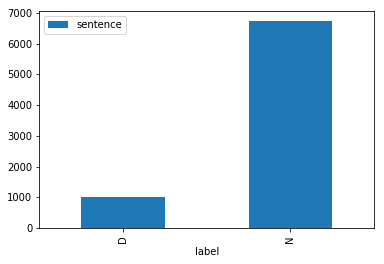

In [6]:
df_label_counts = df.groupby(['label']).count()

result = pd.concat([df_label_counts, df_label_counts.apply(lambda x: x/x.sum())], axis =1)
result.columns = ['count', 'pencentage']
print(result)

df_label_counts.plot(kind='bar')

Our dataset has an *asymetric distribution*

## Data description (Natural Language Processing)

The dataset is mostly natural language. This step involves the application of Natural Language Processing to extract useful data from the *sentences* of the nominations dataset.

Each row of the dataset is already a sentence, so sentence split is unnecesary.

The NLP pipeline for the sentences dataset involves:
1. Remove punctuation and [stopwords](#remove-stopwords)
2. Tokenization (1 to 4 ngrams)
3. Name Entity Recognition (NER)
4. Topic Modelling

### NLP Pipeline

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

The docs of the sklearn tfidfvectorizer state the following:

<cite>
class sklearn.feature_extraction.text.TfidfVectorizer(input=’content’, encoding=’utf-8’, decode_error=’strict’, strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, analyzer=’word’, stop_words=None, token_pattern=’(?u)\b\w\w+\b’, ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.float64’>, norm=’l2’, use_idf=True, smooth_idf=True, sublinear_tf=False)[source]¶
</cite>

We start with a simple approach by producing 1-grams

In [8]:
vec = TfidfVectorizer(lowercase=False, ngram_range=(1,1))

In [9]:
vec_fit = vec.fit_transform(df.sentence)

In [10]:
len(vec.get_feature_names())

10839

In [11]:
# Index of 'D' labeled documents
idx_D_labeled = df.label[df.label == 'D'].index.tolist()

#features of the 'D' labeled documents
vec_fit[idx_D_labeled, :]

<1001x10839 sparse matrix of type '<class 'numpy.float64'>'
	with 24367 stored elements in Compressed Sparse Row format>

Now, take a look at the frequencies of the features in the whole dataset

In [12]:
features_tfidf = pd.Series(vec_fit[idx_D_labeled, :].T.sum(axis=1).ravel().tolist()[0], index=vec.get_feature_names())

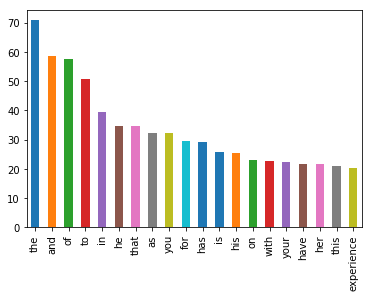

In [13]:
features_tfidf.sort_values(ascending=False)[:20].plot(kind='bar')

The dataset shows a high dimensionality and the top 20 tfidf features are mostly stopwords.

### Remove stopwords

In [14]:
vec = TfidfVectorizer(lowercase=False, ngram_range=(1,1), stop_words='english')

vec_fit = vec.fit_transform(df.sentence)

In [15]:
len(vec.get_feature_names())

10559

Now, take a look at the frequencies of the features in the whole dataset

In [16]:
features_tfidf = pd.Series(vec_fit[idx_D_labeled, :].T.sum(axis=1).ravel().tolist()[0], index=vec.get_feature_names())

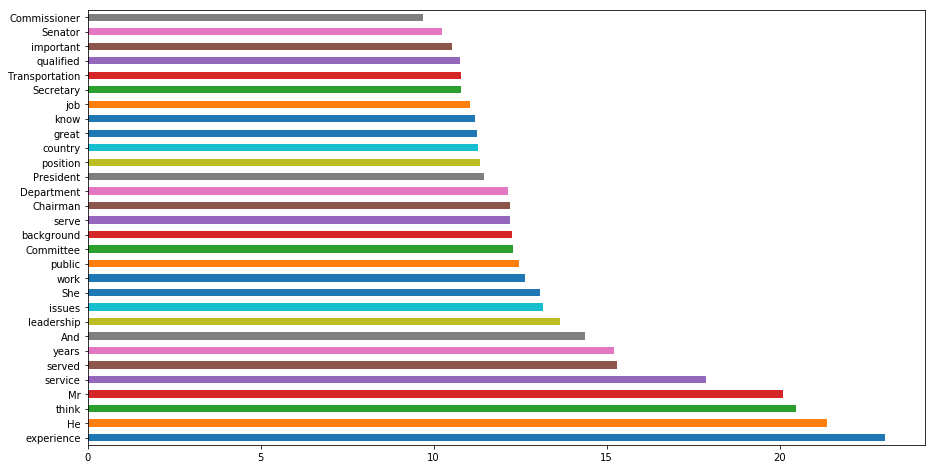

In [17]:
features_tfidf.sort_values(ascending=False)[:30].plot(kind='barh', figsize=(15,8))

### Ngram n=(2,4)

In [18]:
vec = TfidfVectorizer(lowercase=False, ngram_range=(2,4), stop_words='english')

vec_fit = vec.fit_transform(df.sentence)

In [19]:
len(vec.get_feature_names())

234416

Now, take a look at the frequencies of the features in the whole dataset

In [20]:
features_tfidf = pd.Series(vec_fit[idx_D_labeled, :].T.sum(axis=1).ravel().tolist()[0], index=vec.get_feature_names())

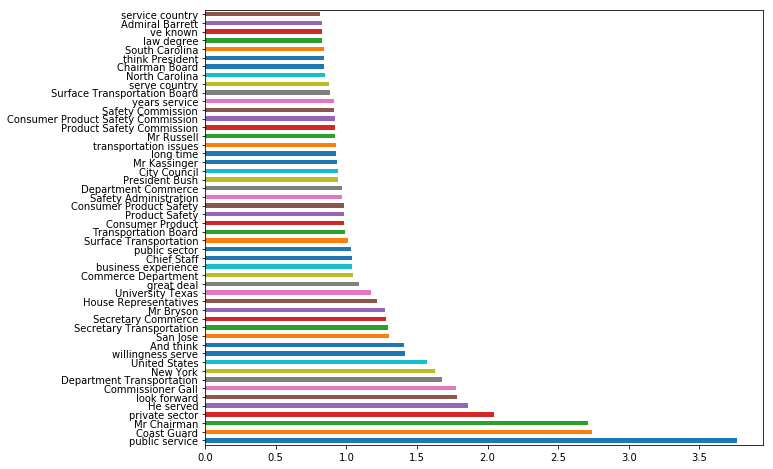

In [21]:
features_tfidf.sort_values(ascending=False)[:50].plot(kind='barh', figsize=(10,8))

There are many names for locations and persons that we could replace with other representative tokens such as LOCATION, ROLE, and NAME.

Next step is to use Name Entity Recognition

### Name Entity Recognition

In [22]:
import textacy

We start by identifying some **keywords** in context. 

The first keyword is 'expertise'

In [23]:
for sent in df.sentence:
    textacy.text_utils.KWIC(sent, keyword='expertise', window_width=35)

and they bring a certain amount of  expertise  to government that we certainly ne
e that you bring a broad range and  expertise  to the position for which you have
dentials and the knowledge and the  expertise  that is consistent with the post. 
Ms. Victory gained a great deal of  expertise  in wireless and satellite issues, 
ittee and brings to this Committee  expertise  in areas such as space and insuran
he state of Florida has caused his  expertise  to be sought out around the countr
an testify as to the character and  expertise  of an individual.                 
nk almost 20 years, he also has an  expertise  in the private sector.            
 increase and a lot of all of this  expertise  had been laid off in the process, 
mean a considerable layoff of that  expertise  and then when the time comes and i
, and you do not have the critical  expertise  in the Department to analyze these
 individual with his technological  expertise  as one of the leaders in the Offic
d in particular 

Another keyword may be 'he/she has'

In [24]:
for sent in df.sentence:
    textacy.text_utils.KWIC(sent, keyword='he has ', window_width=35)

                                  S he has  been a senior lender to communicati
                                  S he has  been a very active leader in our co
                                  S he has  done I think a terrific job in hand
at the Federal/State Joint Board, s he has  represented us in World Radio Commu
  I applaud her for the work that s he has  done, particularly in the area in u
                                    He has  the knowledge, he has the legislati
             He has the knowledge,  he has  the legislative background, he has 
he has the legislative background,  he has  the experience, and he has the abil
ground, he has the experience, and  he has  the ability, I think, to be a very 
member in a biological sense, but s he has  Mr. Chris Hart who is a member of t
                    For her part, s he has  been willing to change her views af
ng time and I appreciate the work s he has  done and the service she has given 
work she has done and the service s he h

Now, create a **Corpus** containing the **Doc** structures for our text. This may take a few minutes, depending on your hardware.

In [25]:
en = textacy.load_spacy('../data/en_core_web_md/en_core_web_md-2.0.0')#spacy.load('en_core_web_md')

In [26]:
corpus = textacy.Corpus(lang='../data/en_core_web_md/en_core_web_md-2.0.0', texts=df.sentence.tolist())
corpus

Corpus(7738 docs; 257978 tokens)

In [27]:
vectorizer = textacy.Vectorizer( tf_type='linear', apply_idf=True, idf_type='smooth', norm='l2',\
                                min_df=2, max_df=0.95
                               )

In [28]:
doc_term_matrix = vectorizer.fit_transform((doc.to_terms_list(ngrams=(2,4), as_strings=True, filter_stops=True, \
                                                             filter_punct=True) \
                                            for doc in corpus))

In [29]:
#for t in corpus[0].to_terms_list(ngrams=(2,4), as_strings=True, named_entities=False, filter_stops=True):
#    print(t)

list(textacy.extract.words(corpus[0], filter_stops=True, filter_punct=True))

[Our,
 special,
 guest,
 this,
 morning,
 as,
 we,
 have,
 our,
 first,
 hearing,
 or,
 the,
 hearing,
 for,
 the,
 reappointment,
 of,
 Ms.,
 Ness,
 to,
 the,
 Federal,
 Communications,
 Commission]

In [30]:
print(repr(doc_term_matrix))

<7738x32586 sparse matrix of type '<class 'numpy.float64'>'
	with 207778 stored elements in Compressed Sparse Row format>


Let's plot the data

In [31]:
features_tfidf = pd.Series(doc_term_matrix[idx_D_labeled, :].T.sum(axis=1).ravel().tolist()[0], index=vectorizer.vocabulary_terms.keys())

In [32]:
features_tfidf.shape

(32586,)

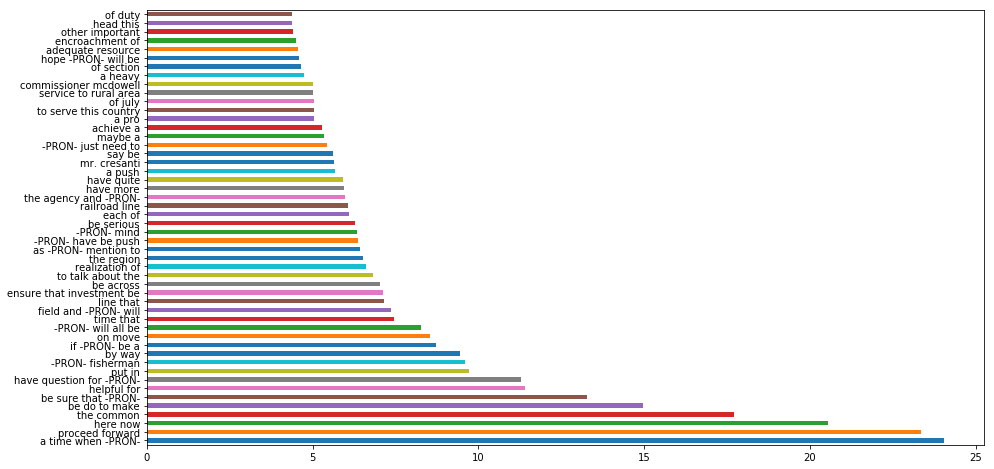

In [33]:
features_tfidf.sort_values(ascending=False)[:50].plot(kind='barh', figsize=(15,8))

### Topic Model

Let's get a **topic model** for this dataset

In [34]:
model = textacy.TopicModel('nmf', n_topics=10)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

(7738, 10)

In [35]:
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=10):
    print('topic', topic_idx, ':', '   '.join(top_terms))

topic 0 : -PRON- be   that -PRON-   and -PRON-   -PRON- will   be a   in the   of -PRON-   -PRON- know   be not   -PRON- can
topic 1 : go to   be go   -PRON- be go to   be go to be   to be   -PRON- be   be go to have   to have   that -PRON- be go   and -PRON- be go
topic 2 : look forward   forward to   -PRON- look forward to   work with   -PRON- look   to work   with -PRON-   to work with -PRON-   look forward to work   forward to work with
topic 3 : of the   one of   one   be one   in the   be one of the   some of   the most   be the   member of
topic 4 : -PRON- have   have a   have be   have to   have get   have have   that -PRON-   and -PRON-   have the   get to
topic 5 : -PRON- would   would like   like to   -PRON- would like to   and -PRON- would like   if -PRON-   would be   would like to know   but -PRON- would like   -PRON- to
topic 6 : -PRON- think   think -PRON-   -PRON- think -PRON- be   and -PRON- think -PRON-   think that   -PRON- think -PRON- have   do -PRON-   think the 

# Conclusion

Data has a skewed class distribution (87%/13% aprox.)
The bag of words approach with ngrams=(2,4) results in more descriptive features. However, most of the features corresponds to entities. 
The Name Entity Recognition approach could lead to improve feature engineering.
Despite of tfidfvectorizer results in more representative features than textacy, the textacy function for contextualization of keywords may help to the interpretation of the features.
Topic models does not seem to help in produce insights with current features.